To - Do:
- Categorize the Data and rerun the FNN model. (Can use same code just organize data) - Sana
- Check the predictions, threshold (0.1,0.2,0.3,0.4) - Sihaam
- Play around with the layers - Sihaam
- Look into pretrained/prebuilt models/architextures. (Tabnet, or tree based models. Random Forest, etc) - Sihaam 
- Categotize the data with a random forest. - Sana

Imports: 

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix,log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
import seaborn as sns
import matplotlib.pyplot as plt



load and process data

In [59]:
df = pd.read_csv("data.csv")
# Encode labels: H = 0 (Healthy), P = 1 (Patient)
df['label'] = df['class'].map({'H': 0, 'P': 1})
df = df.dropna()

# (drop ID and class columns), setting up features
X = df.drop(columns=['ID', 'class', 'label']).values
y = df['label'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


Logistic Regression

In [60]:

# Train logistic regression
model = LogisticRegression(max_iter=5000)  
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nLogistic Regression Accuracy: {acc:.4f}")




Logistic Regression Accuracy: 0.7143


FNN Model

In [61]:
# Build FNN
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Train
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)





Epoch 1/150


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5567 - loss: 0.8330 - val_accuracy: 0.6429 - val_loss: 0.6746
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8423 - loss: 0.3890 - val_accuracy: 0.6786 - val_loss: 0.5299
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8475 - loss: 0.2918 - val_accuracy: 0.7857 - val_loss: 0.4543
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9351 - loss: 0.1936 - val_accuracy: 0.8214 - val_loss: 0.4154
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9810 - loss: 0.1154 - val_accuracy: 0.8214 - val_loss: 0.3807
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8994 - loss: 0.1890 - val_accuracy: 0.8571 - val_loss: 0.3615
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9797 - loss: 0.0889 - val_accuracy: 0.8929 - val_loss: 0.3402
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0532 - val_accuracy: 0.8929 - val_loss: 0.3191
Epoch 9/150

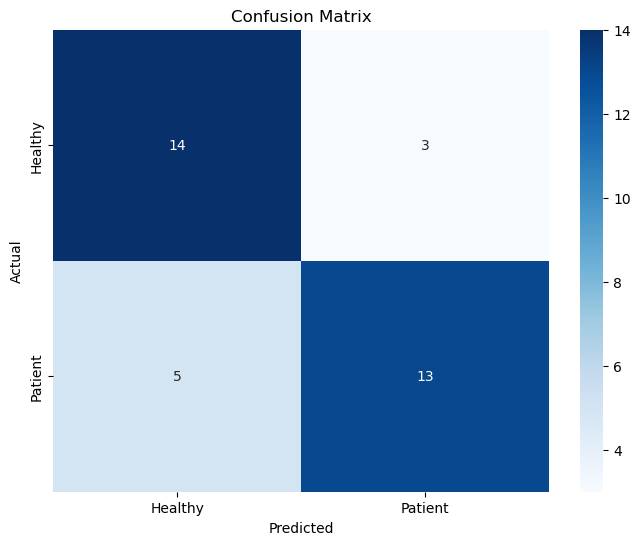

In [62]:
#Print confusion matrix with seaborn
cm = confusion_matrix(y_test, (y_probs > 0.5).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Patient'], yticklabels=['Healthy', 'Patient'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




In [63]:
# Predict raw probabilities (not thresholded)
y_probs = model.predict(X_test)
# Categorize risk levels
low_risk = (y_probs <= 0.33)
medium_risk = (y_probs > 0.33) & (y_probs <= 0.66)
high_risk = (y_probs > 0.66)

# Count total and each category
total = len(y_probs)
low_count = np.sum(low_risk)
med_count = np.sum(medium_risk)
high_count = np.sum(high_risk)

# Calculate percentages
low_pct = low_count / total * 100
med_pct = med_count / total * 100
high_pct = high_count / total * 100

print(f"\nRisk Category Distribution:")
print(f"Low Risk (0.00–0.33): {low_count} data points ({low_pct:.2f}%)")
print(f"Medium Risk (0.34–0.66): {med_count} data points ({med_pct:.2f}%)")
print(f"High Risk (0.67–1.00): {high_count} data points ({high_pct:.2f}%)")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Risk Category Distribution:
Low Risk (0.00–0.33): 21 data points (60.00%)
Medium Risk (0.34–0.66): 1 data points (2.86%)
High Risk (0.67–1.00): 13 data points (37.14%)


Cross Validation

In [64]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, test_idx in kfold.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, verbose=0)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    scores.append(accuracy_score(y_test, y_pred))

print("Cross-validated accuracy: %.4f ± %.4f" % (np.mean(scores), np.std(scores)))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Cross-validated accuracy: 0.8504 ± 0.0341


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predictions after cross-validation: [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0]


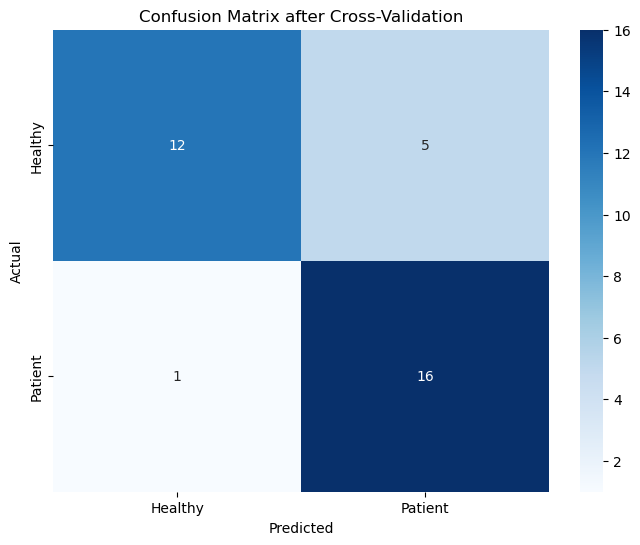

In [65]:
#Print prediction after cross-validation
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Predictions after cross-validation:", y_pred.flatten()) 
#confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Patient'], yticklabels=['Healthy', 'Patient'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix after Cross-Validation')
plt.show()         

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Train Random Forest Classifier

model = RandomForestClassifier(n_estimators=93, random_state=42) #model will use 100 decision trees
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9117647058823529
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.89      0.94      0.91        17

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34



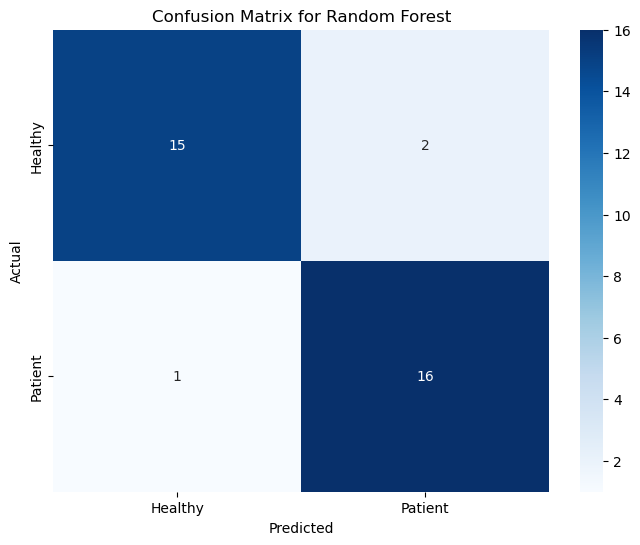

In [67]:
#print confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Patient'], yticklabels=['Healthy', 'Patient'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [68]:
# Categorize risk levels
low_risk = (y_probs <= 0.33)
medium_risk = (y_probs > 0.33) & (y_probs <= 0.66)
high_risk = (y_probs > 0.66)

# Count number of patients in each risk category
low_count = np.sum(low_risk)
med_count = np.sum(medium_risk)
high_count = np.sum(high_risk)
total = len(y_probs)

# Calculate percentages
low_pct = low_count / total * 100
med_pct = med_count / total * 100
high_pct = high_count / total * 100

# Print results
print(f"\nRisk Category Distribution for {total} test patients:")
print(f"Low Risk (0.00–0.33): {low_count} patients ({low_pct:.2f}%)")
print(f"Medium Risk (0.34–0.66): {med_count} patients ({med_pct:.2f}%)")
print(f"High Risk (0.67–1.00): {high_count} patients ({high_pct:.2f}%)")


Risk Category Distribution for 35 test patients:
Low Risk (0.00–0.33): 21 patients (60.00%)
Medium Risk (0.34–0.66): 1 patients (2.86%)
High Risk (0.67–1.00): 13 patients (37.14%)


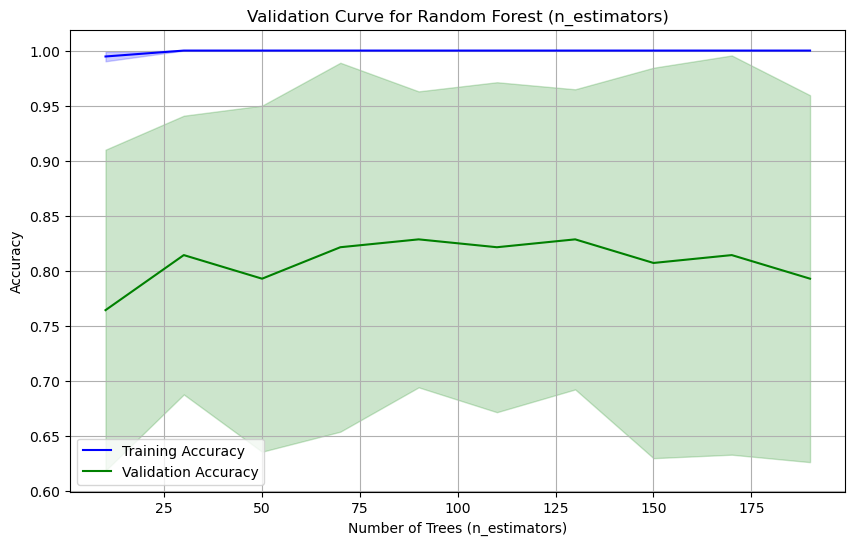

In [69]:
# Define the range of number of trees to test
param_range = np.arange(10, 200, 20)

# Compute training and validation accuracy
train_scores, valid_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Accuracy", color="blue")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(param_range, valid_mean, label="Validation Accuracy", color="green")
plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color="green")

plt.title("Validation Curve for Random Forest (n_estimators)")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()